# Data Mining / Prospecção de Dados

## Sara C. Madeira, 2024/2025

# Project 1 - Pattern Mining

## Logistics 
**_Read Carefully_**

**Students should work in teams of 3 people**. 

Groups with less than 3 people might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `May, 4th (23:59)`.** 

Students should **upload a `.zip` file** containing a folder with all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the `zip` file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202425_P1.ipynb` as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs.**

**Decisions should be justified and results should be critically discussed.** 

Remember that **your notebook should be as clear and organized as possible**, that is, **only the relevant code and experiments should be presented, not everything you tried and did not work, or is not relevant** (that can be discussed in the text, if relevant)! Tables and figures can be used together with text to summarize results and conclusions, improving understanding, readability and concision. **More does not mean better! The target is quality not quantity!**

_**Project solutions containing only code and outputs without discussions will achieve a maximum grade of 10 out of 20.**_

## Dataset and Tools

The dataset to be analysed is **`Foodmart_2025_DM.csv`**, which is a modified and integrated version of the **Foodmart database**, used in several [Kaggle](https://www.kaggle.com) Pattern Mining competitions, with the goal of finding **actionable patterns** by analysing data from the `FOODmart Ltd` company, a leading supermarket chain. 

`FOODmart Ltd` has different types of stores: Deluxe Supermarkets, Gourmet Supermarkets, Mid-Size Grocerys, Small Grocerys and 
Supermarkets. Y

Your **goals** are to find: 
1. **global patterns** (common to all stores) and
2. **local/specific patterns** (related to the type of store).

**`Foodmart_2025_DM.csv`** stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. 

Each transaction (row) has a `STORE_ID` (integer from 1 to 24), and a list of produts (items), together with the quantities bought. 

In the transation highlighted below, a given customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2025_DM_Example.png" alt="Foodmart_2025_DM_Example" style="width: 1000px;"/>

In this context, the project has **2 main tasks**:
1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores **(global patterns)**
2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores **(local/specific patterns)**

# **While doing PATTERN and ASSOCIATION MINING keep in mind the following basic/key questions and BE CREATIVE!**

### 1. What are the most popular products?
* I think we could make a semantics to label items, for instance, foods as healthy or unhealthy and such stuff like that to kinda have a more general notion on what people are buying!!!
    
### 2. Which products are bought together?
### 3. What are the frequent patterns?
### 4. Can we find associations highlighting that when people buy a product/set of products also buy other product(s)?
### 5. Are these associations strong? Can we trust them? Are they misleading?
### 6. Can we analyse these patterns and evaluate these associations to find, not only frequent and strong associations, but also interest patterns and associations?

**In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and [`MLxtend`](http://rasbt.github.io/mlxtend/).**

When using `MLxtend`, frequent patterns can either be discovered using `Apriori` and `FP-Growth`. **Choose the pattern mining algorithm to be used.** 

FP-growth is more efficient with larger datasets than apriori; however it can be memory-intensive, especially for datasets with many frequent items. 


## Team Identification

**GROUP 09**

Students:

* Daniel João - *56455*
* Daniel Ribeiro - *64476*
* 

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first task you should load and preprocessed the dataset **`Foodmart_2025_DM.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

We might need to install an older version of *mlxtend* cuz of the issue we saw on the TP classes:

In [1]:
#!pip install mlxtend==0.19

I recommend that all use a conda environment to keep these packages separate:
(in terminal/ bash)
* 1. Create a conda env: **"conda create -n env_name python=3.9"**
* 2. Activate your conda environment: **"conda activate env_name"**
* 3. Install the correct package version: **"conda install -c conda-forge mlxtend=0.19"**  (THIS IS IMPORTANT)
* 4. Install other packages like pandas and such ...
* 5. Install kernel package so you can use this env has a kernel on Jupyter Notebook: **"conda install -c conda-forge ipykernel"**

### 1.0. Used Packages Importing

In [2]:
import csv
import re
import io
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import plotly.express as px         # it's nice to make plots interactable on the notebook and HTML
import plotly.io as pio
pio.renderers.default = 'notebook_connected'


# mining patterns
# BEWARE mlxtend version 0.19 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth

# association rules
from mlxtend.frequent_patterns import association_rules

**Set pandas to display all columns of a df:**

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# display columns' content fully
pd.set_option('display.max_colwidth', None)

### 1.1. Load and Preprocess Dataset

**Product quantities and stores should not be considered.**

- Removing STORE_ID info; each row is a transaction.
- Values transformation, from Integer to Boolean (One-Hot Encoding):
    - **True** if value > 1,
    - **False** if value = 0.
- each row is a transaction.

APARTE ALGO QUE APANHEI NA AULA A STORA A FALAR
* There is a weird product in it
* There are transactions without ID (111)
* mostra mais do que dois itemsets de 2 vai para item sets grandes, podem ser muitos muitos ate. podes de baixar mesmo muito o support. Ao ter mesmos tantas transações suportes aparentemente pequenos ainda sao até grandes como é relativo ao tamanho enorme do dataset.

#### 1.1.1. Fixing Malformed Lines 

<ins>Fifty-four lines in the CSV are malformed</ins>, having **missing commas** between product types like the following:

In [5]:
filename = "Foodmart_2025_DM.csv"

In [6]:
pattern = re.compile(r'(?<=[0-9])(?=[A-Za-z])')

# Read the file lines
with open(filename, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Find lines that match the pattern
bad_lines = [line.strip() for line in lines if pattern.search(line)]

# Print the first 10 problematic lines
print("Lines with missing commas (showing first 10):")
for line in bad_lines[:10]:
    print(line)

print(len(bad_lines))

Lines with missing commas (showing first 10):
STORE_ID=2,Soup=1Fresh Vegetables=2,Nasal Sprays=2
STORE_ID=2,Soup=2Milk=1,Deli Meats=1,TV Dinner=2,Pancakes=2
STORE_ID=2,Soup=3Fresh Vegetables=3,Cottage Cheese=1,Juice=2,Frozen Vegetables=2
STORE_ID=2,Soup=1Fresh Vegetables=2,Dips=2,Fresh Fruit=1,Dried Fruit=2,Paper Wipes=1,Anchovies=1
STORE_ID=2,Soup=3Fresh Fruit=2,Lightbulbs=3,Wine=2
STORE_ID=2,Soup=2Eggs=1,Personal Hygiene=2,Fresh Fruit=1,Juice=1
STORE_ID=2,Pasta=2Waffles=2,Nuts=2
STORE_ID=2,Soup=2Eggs=3
STORE_ID=2,Soup=2Cereal=1,Juice=1,Ice Cream=1
STORE_ID=2,Soup=1Fresh Vegetables=2,Frozen Chicken=2,Sour Cream=1,Clams=2
54


In [7]:
def extract_items(lines):
    """
    Given a list of transaction lines (each like "STORE_ID=2,ItemA=3,ItemB=1,…"),
    return the set of all product names.

    Args:
      lines (List[str]): raw CSV lines, one transaction per element.

    Returns:
      Set[str]: every distinct key to the left of the “=” (excluding STORE_ID).
    """
    items = set()
    for line in lines:
        # split off the STORE_ID field
        parts = line.split(',')[1:]
        for p in parts:
            if '=' in p:
                # rsplit on the last '=' so we don’t chop product names
                product, qty = p.rsplit('=', 1)
                items.add(product.strip())
    return items

raw_items = extract_items(open(filename).read().splitlines())
cleaned_items = extract_items(re.sub(r'(?<=[0-9])(?=[A-Za-z])', ',', open(filename).read()).splitlines())
print("Raw count:", len(raw_items))        # 136
print("Cleaned count:", len(cleaned_items))# 102
print("Dropped composites:", sorted(raw_items - cleaned_items))


Raw count: 136
Cleaned count: 102
Dropped composites: ['Pasta=1Cleaners', 'Pasta=1Jam', 'Pasta=1Sugar', 'Pasta=2Deli Meats', 'Pasta=2Donuts', 'Pasta=2Fresh Vegetables', 'Pasta=2Waffles', 'Pasta=3Spices', 'Pasta=5Fresh Vegetables', 'Soup=1Cereal', 'Soup=1Cheese', 'Soup=1Chips', 'Soup=1Chocolate Candy', 'Soup=1Cleaners', 'Soup=1Fresh Fruit', 'Soup=1Fresh Vegetables', 'Soup=1Hard Candy', 'Soup=1Peanut Butter', 'Soup=2Cereal', 'Soup=2Cheese', 'Soup=2Chocolate Candy', 'Soup=2Cookies', 'Soup=2Cottage Cheese', 'Soup=2Dried Fruit', 'Soup=2Eggs', 'Soup=2Fresh Vegetables', 'Soup=2Hard Candy', 'Soup=2Milk', 'Soup=2Plastic Utensils', 'Soup=2Rice', 'Soup=3Fresh Fruit', 'Soup=3Fresh Vegetables', 'Soup=4Fresh Fruit', 'Soup=4Milk']


**Fixing that (no number should be immediately before a letter, since the malformed lines only have letters after the number) and opening content in the panda's data frame:**

In [8]:
def process_transaction_csv(filename):
    """
    Reads the CSV file containing transactions, fixes missing commas between key-value pairs,
    processes the transactions, and returns a list of transactions.
    Requires:
        - The CSV file at `filename` is accessible and readable.
        - Each line in the file is formatted with key-value pairs in the format "Key=Value".
        - Some rows may be missing commas between consecutive key-value pairs
          (e.g., "Pasta=2Waffles=2" should be "Pasta=2,Waffles=2").
        - The value for each key is numeric, and only keys with a numeric value above 0 should be considered.
        - Keys that start with a specific prefix (e.g., "STORE_ID") are considered auxiliary and will be ignored.
    Ensures: The function returns a list of transactions, where each transaction is a list of keys (products) 
    that had a numeric value greater than 0.
    Returns: list: A list of transactions, each transaction is a list of product keys.
    """

    with open(filename, "r", encoding="utf-8") as f:
        data = f.read()
    data_fixed = re.sub(r'(?<=[0-9])(?=[A-Za-z])', ',', data)
    
    # Create a file-like object from the fixed data.
    csvfile = io.StringIO(data_fixed)
    reader = csv.reader(csvfile, delimiter=',')
    
    dataset = []
    for row in reader:
        transaction = []
        for kv in row:
            if '=' in kv:
                key, value = kv.split('=', 1)
                key = key.strip()
                value = value.strip()
                
                if key.startswith("STORE_ID"):
                    continue
                try:
                    numeric_value = float(value)
                except ValueError:
                    continue
                if numeric_value > 0:
                    transaction.append(key)
        dataset.append(transaction)
    
    return dataset

dataset = process_transaction_csv(filename)
te = TransactionEncoder()
te_ary = te.fit_transform(dataset)
binary_foodmart = pd.DataFrame(te_ary, columns=te.columns_)

binary_foodmart.head(10)

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,Canned Vegetables,Cereal,Cheese,Chips,Chocolate,Chocolate Candy,Clams,Cleaners,Coffee,Cold Remedies,Computer Magazines,Conditioner,Cookies,Cooking Oil,Cottage Cheese,Crackers,Deli Meats,Deli Salads,Deodorizers,Dips,Donuts,Dried Fruit,Dried Meat,Eggs,Fashion Magazines,Flavored Drinks,French Fries,Fresh Chicken,Fresh Fish,Fresh Fruit,Fresh Vegetables,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,Hot Dogs,Ibuprofen,Ice Cream,Jam,Jelly,Juice,Lightbulbs,Maps,Milk,Mouthwash,Muffins,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,Personal Hygiene,Pizza,Plastic Utensils,Popcorn,Popsicles,Pot Cleaners,Pot Scrubbers,Pots and Pans,Preserves,Pretzels,Rice,Sardines,Sauces,Screwdrivers,Shampoo,Shellfish,Shrimp,Sliced Bread,Soda,Soup,Sour Cream,Spices,Sponges,Sports Magazines,Sugar,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Fal

#### 1.1.2. Foodmart Basic Stats

##### Lines and Columns

- Transcation_number = 69549
- Number of Total Product Types (number of columns) = 102

In [9]:
binary_foodmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69549 entries, 0 to 69548
Columns: 102 entries, Acetominifen to Yogurt
dtypes: bool(102)
memory usage: 6.8 MB


##### Are there empty transactions?

Not anymore, before we were having issues due to the problems in the csv.

In [10]:
binary_foodmart[binary_foodmart.sum(axis=1) == 0]

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,Canned Vegetables,Cereal,Cheese,Chips,Chocolate,Chocolate Candy,Clams,Cleaners,Coffee,Cold Remedies,Computer Magazines,Conditioner,Cookies,Cooking Oil,Cottage Cheese,Crackers,Deli Meats,Deli Salads,Deodorizers,Dips,Donuts,Dried Fruit,Dried Meat,Eggs,Fashion Magazines,Flavored Drinks,French Fries,Fresh Chicken,Fresh Fish,Fresh Fruit,Fresh Vegetables,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,Hot Dogs,Ibuprofen,Ice Cream,Jam,Jelly,Juice,Lightbulbs,Maps,Milk,Mouthwash,Muffins,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,Personal Hygiene,Pizza,Plastic Utensils,Popcorn,Popsicles,Pot Cleaners,Pot Scrubbers,Pots and Pans,Preserves,Pretzels,Rice,Sardines,Sauces,Screwdrivers,Shampoo,Shellfish,Shrimp,Sliced Bread,Soda,Soup,Sour Cream,Spices,Sponges,Sports Magazines,Sugar,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt


In [11]:
empty_count = 0
for check in dataset:
    if check == []: 
        empty_countcount += 1
if empty_count == 0:
    print('No empty transactions.')

No empty transactions.


##### Are there empty columns?

Just by the way we parsed the binary table it would be impossible to have columns with no transactions.

In [12]:
empty_columns = binary_foodmart.columns[binary_foodmart.sum(axis=0) == 0]

if len(empty_columns) > 0:
	print("Empty columns found:", empty_columns.tolist())
else:
	print("No empty columns found.")

No empty columns found.


##### Mean, maximum, minimum and median products per transaction

In [13]:
# each True is treated as 1
product_counts = binary_foodmart.sum(axis=1)

average_products = product_counts.mean()
max_products = product_counts.max()
min_products = product_counts.min()
median_products = product_counts.median()

print("Mean products per transaction:", average_products)
print("Maximum products in a transaction:", max_products)
print("Minimum products in a transaction:", min_products)
print("Median products per transaction:", median_products)

Mean products per transaction: 4.158435060173403
Maximum products in a transaction: 13
Minimum products in a transaction: 1
Median products per transaction: 4.0


##### Absolute Item Frequency of Items

In [14]:
# absolute frequency
freq = binary_foodmart.sum(axis=0).sort_values(ascending=True)
plot_df = freq.reset_index()
plot_df.columns = ['Item', 'Count']

fig = px.bar(
    plot_df,
    x='Count',
    y='Item',
    orientation='h',
    title='Absolute Frequency of Each Item in Foodmart',
    labels={'Count':'Number of Purchases', 'Item':'Product'}
)

# Tweak layout for readability
fig.update_layout(
    height= max(200, len(plot_df)*20), 
    margin=dict(l=150, r=50, t=50, b=50),
)
fig.show()

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support S_min. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least S < S_min.
* Change the minimum support values and discuss the results.

In [17]:
# higher support items will appear first; descendent order
def compute_frequent_itemset_subsets(df, min_support, algorithm='fp_growth'):
    """
    Compute frequent itemsets from a one-hot encoded DataFrame using a specified algorithm and a minimum support threshold,
    and return the frequent itemsets organizsd by their length as separate DataFrames.
    Parameters:
    df : pandas.DataFrame
        A one-hot encoded DataFrame where each row represents a transaction and each column
        represents an item as a boolean value (True/False).
    min_support : float
        A value between 0 and 1 specifies the minimum fraction of transactions in which an itemset 
        must appear to be considered frequent.
    algorithm: str, optional (default='apriori')
        The algorithm to be used for frequent itemset mining. Supported options are 'apriori' and 'fp_growth'.
    Returns:
        A dictionary mapping each itemset length (e.g., 1, 2, 3, …) to a Ddata fame containing the frequent itemsets
        of that length, with their corresponding support values,
        ordered in descending order so that itemsets with higher support appear first.
    """
    if algorithm == 'apriori':
        frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    elif algorithm == 'fp_growth':
        frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    else:
        raise ValueError("Unsupported algorithm. Please use 'apriori' or 'fp_growth'.")
    
    frequent_itemsets['itemset_length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    
    # Organize and sort the frequent itemsets by their length.
    subsets = {}
    for length in sorted(frequent_itemsets['itemset_length'].unique()):
        subset_df = frequent_itemsets[frequent_itemsets['itemset_length'] == length]
        # Order the itemset subset by support in descending order.
        subset_df = subset_df.sort_values(by='support', ascending=False)
        subsets[length] = subset_df
        
    return subsets


**Visualise length itemsets with a key that equals their itemset partition length.**

#### 1.2.0. What Mining Algorithm to Use?

Much faster using FP-Growth.

As expected, when the minimum support threshold is as low as 0.1%, the <ins>FP-Growth algorithm demonstrates significantly faster performance compared to Apriori</ins> because it leverages an efficient data structure known as the FP tree. 

Unlike the Apriori algorithm that generates **candidate itemsets**, **FP-growth compacts the representation of the transactional dataset**, minimising the need for exhaustive candidate generation, and allowing the algorithm to bypass the aforementioned combinatorial explosion. 

Therefore, FP-Growth quickly identifies frequent patterns even amidst a large number of potential itemsets, leading to improvements in execution time under such low support conditions. The computational time improvements are comparatively plotted in the following graph:

In [18]:
support_thresholds = [0.05, 0.04, 0.03, 0.02, 0.01, 0.0075, 0.005]
results = []

for support in support_thresholds:
    start_time = time.time()
    _ = compute_frequent_itemset_subsets(binary_foodmart, min_support=support, algorithm='apriori')
    apriori_time = time.time() - start_time
    results.append({'Support': support * 100, 'Time': apriori_time, 'Algorithm': 'Apriori'})
    
    start_time = time.time()
    _ = compute_frequent_itemset_subsets(binary_foodmart, min_support=support, algorithm='fp_growth')
    fpgrowth_time = time.time() - start_time
    results.append({'Support': support * 100, 'Time': fpgrowth_time, 'Algorithm': 'FP-Growth'})


In [21]:
df_times = pd.DataFrame(results)
df_times['Support_label'] = df_times['Support'].map(lambda x: f"{x:.2f}%")

df_times

,Support,Time,Algorithm,Support_label
0,5.00,0.153505,Apriori,5.00%
1,5.00,0.204162,FP-Growth,5.00%
2,4.00,0.265676,Apriori,4.00%
3,4.00,0.364583,FP-Growth,4.00%
4,3.00,0.307575,Apriori,3.00%
5,3.00,0.340840,FP-Growth,3.00%
6,2.00,0.567766,Apriori,2.00%
7,2.00,0.455251,FP-Growth,2.00%
8,1.00,1.786453,Apriori,1.00%
9,1.00,0.612005,FP-Growth,1.00%


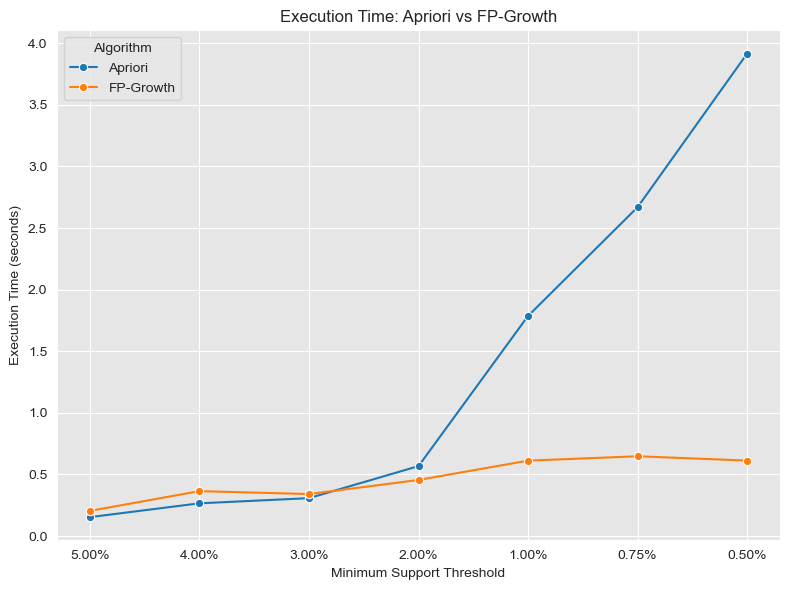

In [27]:
support_order = sorted(df_times['Support_label'].unique(),
                       key=lambda s: float(s.strip('%')), reverse=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8, 6))

ax = sns.lineplot(
    data=df_times,
    x='Support_label',
    y='Time',
    hue='Algorithm',
    marker='o',
    sort=False  
)

ax.set_title('Execution Time: Apriori vs FP-Growth')
ax.set_xlabel('Minimum Support Threshold')
ax.set_ylabel('Execution Time (seconds)')
ax.set_xticks(support_order)
ax.set_xticklabels(support_order)
plt.tight_layout()
plt.show()

#### 1.2.1. Minimum Relative Support Threshold

**Support** (relative support) is the proportion of transactions in a dataset that contain a specific itemset, and ranges from 0 to 1.  
For example, if an itemset appears in 5 out of 10 transactions, its support is 0.5 (50%).

The **minimum support threshold** is the cutoff that we set:
<ins>any itemset with support below this value is discarded</ins>, while those above it are considered ***frequent*** and are used to generate association rules.

Nonetheless, it’s important to understand that **support is a relative metric**, depending on the total number of transactions in the dataset.

- A `0.5%` minimum support means an itemset must appear in **at least ~348 transactions** to be considered frequent.  
  This can be a significant threshold, especially for **larger itemsets**, which naturally occur less often.

- In contrast, a `0.01%` minimum support means an itemset only needs to appear in **about 7 transactions**.  
  This can allow **too many low-frequency or noisy patterns** into the results, which may bloat the output and reduce the overall quality of insights.

To choose a practical minimum support, it's useful to plot the number of frequent itemsets against varying thresholds. **As minimum support decreases, the number of patterns typically grows exponentially**. The ***“elbow point”*** in this curve <ins>is where the growth rate sharply increases, suggesting a balanced threshold that captures meaningful patterns</ins> without introducing excessive noise.

To select a practical **minimum-support threshold**, it's to plot the number of frequent itemsets againstof the varying support threshold. As the support is lowered, the count of frequent itemsets typically grows *(often exponentially)*, producing a sharp inflection, aka a **“elbow point”** , in the curve. This elbow marks a **sweet spot**: 
 * **it captures most of the meaningful patterns** 
 * **while avoiding an explosion (exponential growth) of trivial or noisy itemsets**.


In [ ]:
min_sup_values = []
itemset_counts = []

# Generate thresholds from 5.0% to 0.1% in 0.1% steps (i.e., 0.001 in fraction)
for min_sup in np.arange(0.05, 0.0009, -0.001):
    try:
        frequent_itemsets = fpgrowth(binary_foodmart, min_support=min_sup, use_colnames=True)
        num_itemsets = len(frequent_itemsets)
        min_sup_values.append(round(min_sup * 100, 3))  # Convert to percentage
        itemset_counts.append(num_itemsets)
    except Exception as e:
        print(f"Error at min_sup = {min_sup*100:.3f}%: {e}")
        break

results_df = pd.DataFrame({
    'Minimum Support (%)': min_sup_values,
    'Number of Frequent Itemsets': itemset_counts
})

results_df['Jump'] = results_df['Number of Frequent Itemsets'].diff().fillna(0).astype(int)
results_df

,Minimum Support (%),Number of Frequent Itemsets,Jump
0,5.0,32,0
1,4.9,33,1
2,4.8,33,0
3,4.7,33,0
4,4.6,33,0
5,4.5,33,0
6,4.4,33,0
7,4.3,33,0
8,4.2,35,2
9,4.1,39,4


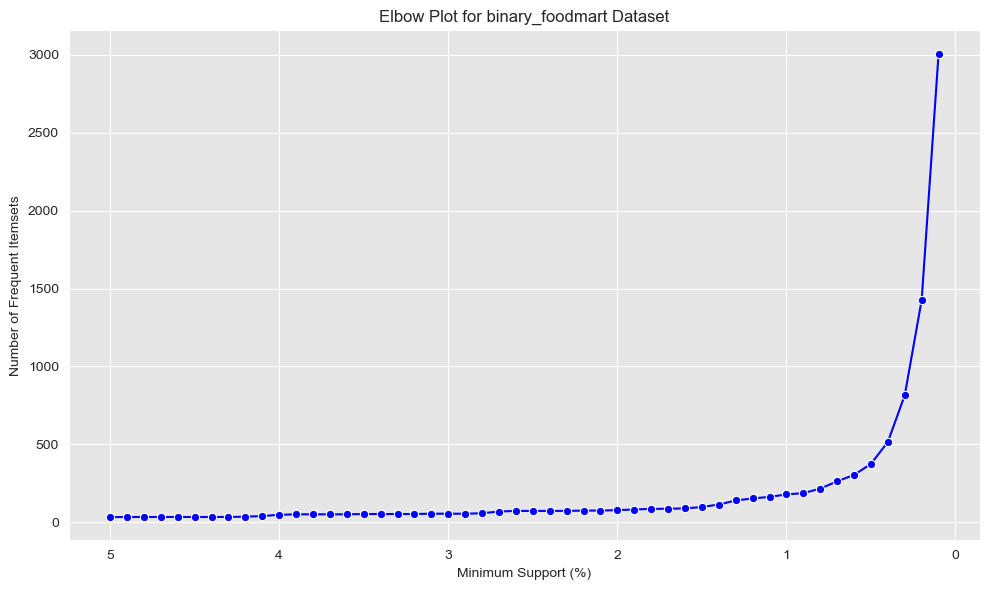

In [35]:
# Plot the elbow curve
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Minimum Support (%)', y='Number of Frequent Itemsets', data=results_df, marker='o', color='blue')
plt.xlabel('Minimum Support (%)')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Elbow Plot for binary_foodmart Dataset')
plt.gca().invert_xaxis()  # Higher support on the left
plt.grid(True)
plt.tight_layout()
plt.show()

##### Elbow Point Results

- **5.0% → 3.0%**: Slow growth (32 → 54 itemsets), capturing only the most frequent patterns.  
- **3.0% → 2.0%**: Moderate growth (54 → 77), still manageable.  
- **2.0% → 1.5%**: Slight uptick (77 → 97).  
- **1.5% → 1.0%**: Noticeable jump (97 → 178), marking the start of steeper growth.  
- **1.0% → 0.5%**: More than doubles (178 → 374).  
- **0.5% → 0.1%**: Explosive increase (374 → 3009), indicating many rare/noisy itemsets.

Based on this, the elbow point appears to be around 1.5% to 1.0%, because this range balances pattern coverage and noise:

- **1.5%** yields **97** itemsets— compact, high‑confidence patterns.  
- **1.0%** yields **178** itemsets- broader coverage yet still manageable.  
- **0.5%** yields **374** itemsets— much broader coverage, may not be manageable.  (probably elbow point!)
- <ins>Below 0.5%, itemsets explode, burdening computation and including trivial rules</ins>.

**ELBOW POINT SEEMS TO BE 0.5%, TLDR**:
 * Above 0.5%: you capture the strongest patterns without generating too many rules.
 * Below 0.5%: rule counts explode, making interpretation and filtering unwieldy.



##### Minimum Support Threshold = 5%

Each itemset show up in at least ~3478 transactions.

In [39]:
S_min_high = 0.05
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high)
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 2 itemsets of differing lengths.


In [40]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
1,0.284461,(Fresh Vegetables),1
12,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
3,0.117845,(Cheese),1
14,0.117227,(Dried Fruit),1
4,0.105422,(Cookies),1
29,0.080677,(Wine),1
15,0.078966,(Paper Wipes),1
20,0.078549,(Canned Vegetables),1
22,0.068340,(Frozen Vegetables),1


In [41]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2]

Frequent itemsets of 2 items


,support,itemsets,itemset_length
31,0.050971,"(Fresh Vegetables, Fresh Fruit)",2


##### Mininum Support Threshhold = 1%

Each itemset show up in at least ~696 transactions.

In [42]:
S_min_high = 0.01
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high)
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 2 itemsets of differing lengths.


In [43]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [44]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
134,0.050971,"(Fresh Vegetables, Fresh Fruit)",2
102,0.035701,"(Soup, Fresh Vegetables)",2
138,0.035284,"(Fresh Vegetables, Dried Fruit)",2
110,0.031201,"(Fresh Vegetables, Cheese)",2
112,0.027765,"(Fresh Vegetables, Cookies)",2
...,...,...,...
121,0.010281,"(Fresh Vegetables, Cleaners)",2
157,0.010194,"(Frozen Vegetables, Fresh Fruit)",2
155,0.010165,"(Popcorn, Fresh Vegetables)",2
175,0.010137,"(Wine, Dried Fruit)",2


##### Minimum Support Threshold = 0.5%

Each itemset show up in at least ~347 transactions.

In [57]:
S_min_high = 0.005
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high, "fp_growth")
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 3 itemsets of differing lengths.


In [58]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [59]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
212,0.050971,"(Fresh Vegetables, Fresh Fruit)",2
102,0.035701,"(Fresh Vegetables, Soup)",2
224,0.035284,"(Fresh Vegetables, Dried Fruit)",2
122,0.031201,"(Cheese, Fresh Vegetables)",2
129,0.027765,"(Fresh Vegetables, Cookies)",2
...,...,...,...
157,0.005018,"(Dips, Cookies)",2
329,0.005018,"(Frozen Chicken, Cookies)",2
301,0.005004,"(Lightbulbs, Paper Wipes)",2
109,0.005004,"(Cheese, Pasta)",2


In [60]:
print("Frequent itemsets of 3 items")
frequent_subsets_high[3].sort_values(by='support', ascending=False)

Frequent itemsets of 3 items


,support,itemsets,itemset_length
104,0.007089,"(Fresh Vegetables, Fresh Fruit, Soup)",3
134,0.005550,"(Fresh Vegetables, Fresh Fruit, Cookies)",3
123,0.005334,"(Cheese, Fresh Vegetables, Fresh Fruit)",3


##### Minimum Support Threshold = 0.1%

Each itemset show up in at least ~70 transactions.

In [38]:
S_min_high = 0.001
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high, "fp_growth")
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 3 itemsets of differing lengths.


In [39]:
print("Frequent itemsets of 1 items")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 items


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [40]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
1121,0.050971,"(Fresh Vegetables, Fresh Fruit)",2
102,0.035701,"(Fresh Vegetables, Soup)",2
1193,0.035284,"(Fresh Vegetables, Dried Fruit)",2
222,0.031201,"(Fresh Vegetables, Cheese)",2
327,0.027765,"(Fresh Vegetables, Cookies)",2
...,...,...,...
594,0.001006,"(Tofu, Sour Cream)",2
2551,0.001006,"(Home Magazines, Juice)",2
289,0.001006,"(Peanut Butter, Hard Candy)",2
1832,0.001006,"(Hamburger, Mouthwash)",2


In [41]:
print("Frequent itemsets of 3 items")
frequent_subsets_high[3].sort_values(by='support', ascending=False)

Frequent itemsets of 3 items


,support,itemsets,itemset_length
104,0.007089,"(Fresh Vegetables, Soup, Fresh Fruit)",3
332,0.005550,"(Fresh Vegetables, Cookies, Fresh Fruit)",3
225,0.005334,"(Fresh Vegetables, Cheese, Fresh Fruit)",3
1200,0.004975,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)",3
1213,0.004702,"(Fresh Vegetables, Paper Wipes, Fresh Fruit)",3
...,...,...,...
1356,0.001006,"(Frozen Vegetables, Fresh Vegetables, Chips)",3
1581,0.001006,"(Coffee, Fresh Vegetables, Chips)",3
313,0.001006,"(Soup, Fresh Vegetables, Hard Candy)",3
2840,0.001006,"(Fresh Vegetables, Pizza, Cereal)",3


#### 1.2.2. Discussing Results

Initially, setting the minimum support threshold to **5%** yielded a relatively limited set of frequent itemsets. Under this stringent criterion, only the strongest individual items emerged as frequent, and only one pair, ‘fresh fruit and fresh vegetables’, was identified as a frequent 2-itemset. This result illustrates that a higher support level effectively filters out less common or weaker associations, ensuring that only the most dominant patterns, which appear in a substantial fraction of transactions, are retained. **This is particularly advantageous when the analysis aims to capture exclusively robust and reliable associations.**

Lowering the threshold to **1%** led to a marked increase in the number of frequent itemsets. The pool of frequent 1-itemsets expanded considerably to include a wider range of items, and the number of 2-itemsets also rose, thereby revealing more nuanced co-occurrence patterns that were previously obscured. At this level, each itemset appears in roughly 695 transactions (a nontrivial criterion), yet it still uncovers associations with significant potential value.

A further reduction of the support threshold to **0.5%** produced an even more dramatic rise in the number of frequent itemsets, including the appearance of 3 itemsets. Under these conditions, the algorithm captured a diverse array of item combinations, unveiling more intricate interactions among products. However, lowering the support this far also increases the likelihood of incorporating **statistically insignificant patterns**, as noise begins to infiltrate the results.

Essentially, setting the support threshold to around **1.5%** or **1%** produces a leaner, more meaningful rule set with minimal computational overhead; the algorithm returns a focused collection of frequent itemsets while excluding less common, often less significant, patterns. Conversely, reducing the threshold to **0.5%** (the detected elbow point) reveals a substantially larger number of itemsets, including higher-order combinations; however, this richer diversity may also bring additional noise. Some residual noise may later be pruned through additional rule-level thresholds, such as confidence and lift cutoffs.

Minimum Support Thresholds just a few decimals below **0.5%** are already likely to introduce excessive noise and result in impractically bloated outputs, which is why we decided against pursuing them. 

### 1.3. Generate Association Rules from Frequent Itemsets

##### To Do:

Using a minimum support S_min fundamented by the previous results. 
* Generate association rules with a chosen value (C) for minimum confidence. 
* Generate association rules with a chosen value (L) for minimum lift. 
* Generate association rules with both confidence >= C and lift >= L.
* Change C and L when it makes sense and discuss the results.
* Use other metrics besides confidence and lift.
* Evaluate how good the rules are given the metrics and how interesting they are from your point of view.

#### 1.3.0. What are Association Rules


An association rule implies that if itemset **X** occurs, then itemset **Y** also occurs with a certain probability. It is defined as an implication: `X → Y` where **X** (the _antecedent_) and **Y** (the _consequent_) are disjoint subsets (no item in common) of the full itemset **I** (X, Y ⊆ I and X ∩ Y = ∅).

**Example:** 
 * `{Bacon, Egg} → {Milk}`  
 * `Itemset = {Bacon, Egg, Milk}`

There are <ins>various metrics that evaluate the perceived strength of assosciation</ins> between **antecedent** and **consequent**:

 * Support
 * Confidence
 * Lift or Correlation or interest
 * Leverage
 * Conviction



#### 1.3.1 Association Rules for Confidence

**Confidence**: is a measure of <ins>how often items in a rule are found together</ins>.
* Confidence helps rank rules by how strong they are.
* But confidence does not account for the overall frequency of B (for that, lift is used).

$$
\text{Confidence}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A)}
$$

**Confidence** evaluates the probability that **B** will be purchased/ occur if **A** is purchased/ occurs. Ranges from 0 to 1:

- **High Confidence (close to 1)**: This means that **B** is very likely to appear in transactions that already contain **A**. This implies a strong association between **A** and **B**.
  
- **Low Confidence (close to 0)**: This means that **B** is not likely to appear in transactions that contain **A**. In this case, the association between **A** and **B** is weak.


In [ ]:
# Rules computing them at 6 different support levels
support_levels    = [0.05, 0.01, 0.005, 0.001, 0.0008, 0.0005]
confidence_levels = np.arange(0.1, 1.0, 0.1)

# Sweep FP‑Growth and count rules
rules_counts = {sup: [] for sup in support_levels}
for sup in support_levels:
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    for conf in confidence_levels:
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=conf)
        rules_counts[sup].append(len(rules))

records = []
for sup in support_levels:
    for conf, cnt in zip(confidence_levels, rules_counts[sup]):
        records.append({
            'Min Support (%)': f"{sup*100:.4f}",
            'Confidence': conf,
            'Num Rules': cnt
        })
plot_df = pd.DataFrame(records)

#  Plotting the results
fig = px.line(
    plot_df,
    x="Confidence",
    y="Num Rules",
    facet_col="Min Support (%)",
    facet_col_wrap=3,
    markers=True,
    title="Rules vs. Confidence for Different Support Levels",
    labels={"Num Rules":"Number of Rules"}
)

# Share axes
fig.update_yaxes(matches="y")
fig.update_xaxes(matches="x")
fig.update_layout(
    height=600,
    width=900,
    margin=dict(t=80, b=50, l=50, r=50)
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1] + "%"))
fig.show()

The six‐panel chart makes clear how dramatically the size of our rule set depends on the support threshold. At **5% support**, there are virtually no rules once you raise confidence above 10%, even at 10% confidence, only a couple of trivial pairs survive. Dropping to **1% support** yields about 80–90 rules at 10% confidence, but they all vanish by 30% confidence, so these are very coarse, generic associations. 

At **0.5% support**, a healthy pool of roughly 250 rules at 10% confidence is finally seen, which thins to fewer than ten by 30%. This is the classic “elbow” region where there is a balance of coverage and manageability. Pushing support lower (0.1%, 0.08%, 0.05%) unleashes thousands of rules at low confidence but still collapses to zero by 40%–50%, flooding the output with ***low value associations***.

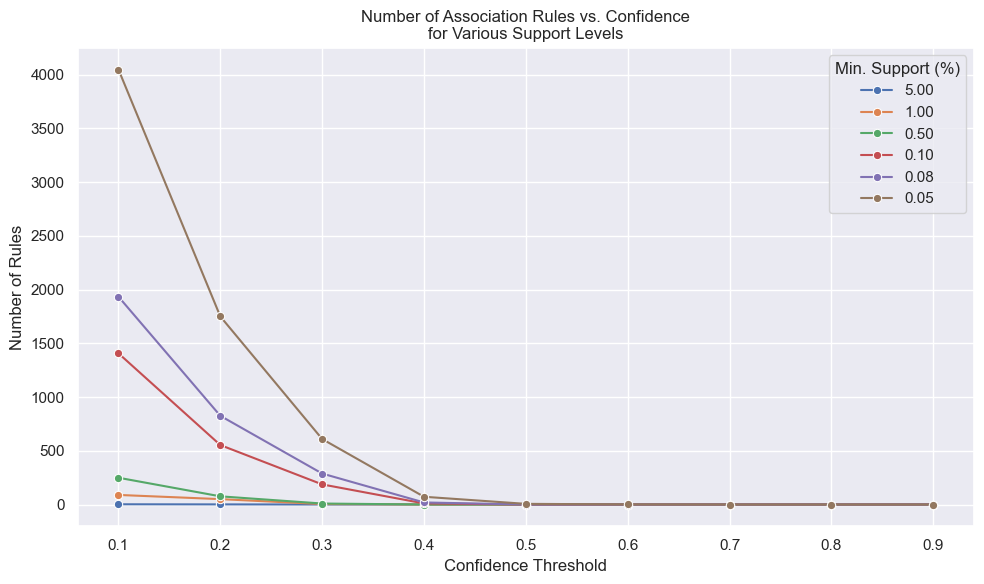

In [ ]:
# Rules computing them at 6 different support levels
support_levels    = [0.05, 0.01, 0.005, 0.001, 0.0008, 0.0005]
confidence_levels = np.arange(0.1, 1.0, 0.1)

# Sweep FP‑Growth and count rules
rules_counts = {sup: [] for sup in support_levels}
for sup in support_levels:
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    for conf in confidence_levels:
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=conf)
        rules_counts[sup].append(len(rules))
        
records = []
for sup in support_levels:
    for conf, cnt in zip(confidence_levels, rules_counts[sup]):
        records.append({
            'Support (%)': f"{sup*100:.2f}",
            'Confidence': conf,
            'Num Rules': cnt
        })
plot_df = pd.DataFrame.from_records(records)

# All in one plot
sns.set(style="darkgrid", palette="deep")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=plot_df,
    x="Confidence",
    y="Num Rules",
    hue="Support (%)",
    marker="o"
)
ax.set_title("Number of Association Rules vs. Confidence\nfor Various Support Levels")
ax.set_ylabel("Number of Rules")
ax.set_xlabel("Confidence Threshold")
plt.legend(title="Min. Support (%)")
plt.tight_layout()
plt.show()


Overlaying all six curves in a single plot drives home the same point:  
- high‐support curves sit flat near zero,  
- ultra‐low support curves skyrocket into the thousands at low confidence,  
- only the mid‐range supports (0.5–0.1%) give you a substantial—but still limited—number of rules that disappear quickly as you raise confidence.

For a concise, high‑value rule set choosing **min_support ≈ 0.5%** with **min_confidence 20–30%** (yielding a few dozen solid rules) or, for broader coverage, **min_support ≈ 0.1%** with **conf ≥ 20%** is probably for the better. It results in couple hundred rules that can be **further pruned by lift or leverage**.  


In [15]:
_RULE_COLS = [
    'antecedents', 'consequents',
    'support', 'count',
    'confidence', 'lift',
    'leverage', 'conviction'
]

def generate_rules(
    df: pd.DataFrame,
    min_support = 0.01,
    metric = 'confidence',
    min_threshold = 0.1):
    """
    Run FP-Growth + association_rules on a binary-encoded DataFrame.

    Requires:
    df : pd.DataFrame
        One-hot / binary-encoded transactions (columns=items, rows=transactions).
    min_support : float
        Minimum support for FP-Growth (e.g. 0.01 for 1%).
    metric : str, default='confidence'
        Which metric to use for filtering rules.  
        Options include 'confidence', 'lift', 'leverage', 'conviction'.
    min_threshold : float, default=0.1
        Minimum threshold for the chosen metric (e.g. 0.1 for 10% confidence).

    Returns:
    pd.DataFrame
        Association rules, with columns:
        antecedents, consequents, support, count, confidence, lift, leverage, conviction.
    """
    freq_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    
    # association rules
    rules = association_rules(
        freq_itemsets,
        metric=metric,
        min_threshold=min_threshold
    )
    
    # add absolute counts
    n_trans = df.shape[0]
    rules['count'] = rules['support'] * n_trans
    
    return rules[_RULE_COLS].copy()


##### Association Rules - Minimum Support Threshold == 1%

In [142]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='confidence', min_threshold=0.1)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('confidence', ascending=False).head(20)


Number of rules generated: 89


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
72,(Shampoo),(Fresh Vegetables),0.012667,881.0,0.308906,1.085933,0.001002,1.035371
39,(Donuts),(Fresh Vegetables),0.012466,867.0,0.308541,1.084650,0.000973,1.034824
35,(Personal Hygiene),(Fresh Vegetables),0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
46,(Dried Fruit),(Fresh Vegetables),0.035284,2454.0,0.300993,1.058118,0.001938,1.023651
36,(Hot Dogs),(Fresh Vegetables),0.012107,842.0,0.299431,1.052625,0.000605,1.021368
1,(Soup),(Fresh Vegetables),0.035701,2483.0,0.297365,1.045363,0.001549,1.018365
31,(Deli Meats),(Fresh Vegetables),0.015902,1106.0,0.296594,1.042652,0.000651,1.017249
81,(Nuts),(Fresh Vegetables),0.019828,1379.0,0.295163,1.037620,0.000719,1.015183
38,(Bologna),(Fresh Vegetables),0.011948,831.0,0.294055,1.033727,0.000390,1.013590
79,(TV Dinner),(Fresh Vegetables),0.012250,852.0,0.293086,1.030318,0.000360,1.012200


In [ ]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='confidence', min_threshold=0.2)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('confidence', ascending=False).head(20)

,antecedents,consequents,support,count,confidence,lift,leverage,conviction
38,(Shampoo),(Fresh Vegetables),0.012667,881.0,0.308906,1.085933,0.001002,1.035371
21,(Donuts),(Fresh Vegetables),0.012466,867.0,0.308541,1.084650,0.000973,1.034824
17,(Personal Hygiene),(Fresh Vegetables),0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
25,(Dried Fruit),(Fresh Vegetables),0.035284,2454.0,0.300993,1.058118,0.001938,1.023651
18,(Hot Dogs),(Fresh Vegetables),0.012107,842.0,0.299431,1.052625,0.000605,1.021368
0,(Soup),(Fresh Vegetables),0.035701,2483.0,0.297365,1.045363,0.001549,1.018365
13,(Deli Meats),(Fresh Vegetables),0.015902,1106.0,0.296594,1.042652,0.000651,1.017249
46,(Nuts),(Fresh Vegetables),0.019828,1379.0,0.295163,1.037620,0.000719,1.015183
20,(Bologna),(Fresh Vegetables),0.011948,831.0,0.294055,1.033727,0.000390,1.013590
45,(TV Dinner),(Fresh Vegetables),0.012250,852.0,0.293086,1.030318,0.000360,1.012200


In [143]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='confidence', min_threshold=0.3)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 4


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
3,(Shampoo),(Fresh Vegetables),0.012667,881.0,0.308906,1.085933,0.001002,1.035371
1,(Donuts),(Fresh Vegetables),0.012466,867.0,0.308541,1.084650,0.000973,1.034824
0,(Personal Hygiene),(Fresh Vegetables),0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
2,(Dried Fruit),(Fresh Vegetables),0.035284,2454.0,0.300993,1.058118,0.001938,1.023651


##### Association Rules - Minimum Support Threshold == 0.5%

In [ ]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='confidence', min_threshold=0.1)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 249


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
6,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.007089,493.0,0.340705,1.197720,0.001170,1.085309
239,(Aspirin),(Fresh Vegetables),0.008613,599.0,0.322911,1.135167,0.001026,1.056787
200,(Hamburger),(Fresh Vegetables),0.008943,622.0,0.316057,1.111072,0.000894,1.046196
33,(Hard Candy),(Fresh Vegetables),0.008512,592.0,0.309138,1.086750,0.000679,1.035719
186,(Shampoo),(Fresh Vegetables),0.012667,881.0,0.308906,1.085933,0.001002,1.035371
105,(Donuts),(Fresh Vegetables),0.012466,867.0,0.308541,1.084650,0.000973,1.034824
232,(Sugar),(Fresh Vegetables),0.008296,577.0,0.303365,1.066454,0.000517,1.027136
90,(Personal Hygiene),(Fresh Vegetables),0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
121,(Dried Fruit),(Fresh Vegetables),0.035284,2454.0,0.300993,1.058118,0.001938,1.023651
95,(Hot Dogs),(Fresh Vegetables),0.012107,842.0,0.299431,1.052625,0.000605,1.021368


In [145]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='confidence', min_threshold=0.2)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 76


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
1,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.007089,493.0,0.340705,1.197720,0.001170,1.085309
70,(Aspirin),(Fresh Vegetables),0.008613,599.0,0.322911,1.135167,0.001026,1.056787
55,(Hamburger),(Fresh Vegetables),0.008943,622.0,0.316057,1.111072,0.000894,1.046196
8,(Hard Candy),(Fresh Vegetables),0.008512,592.0,0.309138,1.086750,0.000679,1.035719
49,(Shampoo),(Fresh Vegetables),0.012667,881.0,0.308906,1.085933,0.001002,1.035371
31,(Donuts),(Fresh Vegetables),0.012466,867.0,0.308541,1.084650,0.000973,1.034824
67,(Sugar),(Fresh Vegetables),0.008296,577.0,0.303365,1.066454,0.000517,1.027136
26,(Personal Hygiene),(Fresh Vegetables),0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
35,(Dried Fruit),(Fresh Vegetables),0.035284,2454.0,0.300993,1.058118,0.001938,1.023651
27,(Hot Dogs),(Fresh Vegetables),0.012107,842.0,0.299431,1.052625,0.000605,1.021368


In [146]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='confidence', min_threshold=0.3)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('confidence', ascending=False).head(20)

Number of rules generated: 9


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
0,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.007089,493.0,0.340705,1.197720,0.001170,1.085309
8,(Aspirin),(Fresh Vegetables),0.008613,599.0,0.322911,1.135167,0.001026,1.056787
6,(Hamburger),(Fresh Vegetables),0.008943,622.0,0.316057,1.111072,0.000894,1.046196
1,(Hard Candy),(Fresh Vegetables),0.008512,592.0,0.309138,1.086750,0.000679,1.035719
5,(Shampoo),(Fresh Vegetables),0.012667,881.0,0.308906,1.085933,0.001002,1.035371
3,(Donuts),(Fresh Vegetables),0.012466,867.0,0.308541,1.084650,0.000973,1.034824
7,(Sugar),(Fresh Vegetables),0.008296,577.0,0.303365,1.066454,0.000517,1.027136
2,(Personal Hygiene),(Fresh Vegetables),0.016506,1148.0,0.302185,1.062305,0.000968,1.025399
4,(Dried Fruit),(Fresh Vegetables),0.035284,2454.0,0.300993,1.058118,0.001938,1.023651


##### 1.3.1.1. Discussing Results

When we set **min_support = 1%** and **min_confidence = 10%**, FP‑Growth yields 89 rules—but they all point to **Fresh Vegetables** and have very modest lift (1.02–1.09). In other words, at this support level every single‐item antecedent (Shampoo, Donuts, Soup, etc.) appears only marginally more often with Fresh Vegetables than at random, producing weak, generic associations.  
Raising the confidence floor to **20%** at the same support cuts the rules down to just four `Shampoo, Donuts, Personal Hygiene or Dried Fruit → Fresh Vegetables`. This confirms that single‑item rules at 1% support lack both strength and variety (support is probably too high).

Dropping support to **0.5%** dramatically expands the rule‐set. At **10% confidence** we find 249 rules, including **multi‑item antecedents** such as `{Soup, Fresh Fruit} → {Fresh Vegetables}` with confidence 34% and lift 1.20. This two‑item rule is our strongest actionable insight, revealing a nontrivial cross‑sell pattern that never appeared at 1% support. Raising confidence to **20%** still leaves 76 rules (many multi‑item), and at **30%** we retain only nine rules—chiefly those with the highest lift and confidence.

These results confirm three key points:  
1. **High‐support thresholds** (≥ 1%) produce too few and too weak single‑item rules.  
2. **Mid‐range support** (≈ 0.5%) is required before meaningful multi‑item patterns emerge.  
3. **Moderate confidence thresholds** (20–30%) strike the best balance between rule quality and quantity—yielding a manageable set of high‑impact rules.

Here, it's also important to note the **fundamental issue with low support, high confidence associations**. When support drops into the extreme low single digits (say below 0.1 %), a rule may achieve spectacular confidence simply because it is calculated on a handful of baskets.

Essentially, with so little evidence, **one extra transaction can swing the percentage wildly**, and the **apparent association may be nothing more than a random coincidence found after testing thousands of rare item pairs**. This “**small numbers illusion**” is amplified when the consequent is a common product: any rare antecedent that occurs with it two or three times inherits a high confidence, even though it offers no real predictive power.

To avoid acting on such brittle patterns, **it’s ESSENTIAL to add a lift (or leverage) filter after the confidence cut off**; lift compares the observed co-purchase rate with what would be expected by chance and quickly exposes rules whose impressive confidence is driven by popularity rather than true affinity. Only the rules that survive both the lift screen and a sensible minimum support can be considered genuinely robust and worth operational attention.

#### 1.3.2 Association Rules for Lift (*without confidence*)

**Lift**: evaluate the strength of a rule beyond making sure it's not just by chance. It measures how much more likely two items are to appear together, compared to being independent.
* <ins>**THE BIG DIFFERENCE**</ins>: **Confidence** measures how likely B is given A, but it does not account for the relative frequencies of A and B. This means that high confidence does not always imply a strong relationship between A and B. **Lift**, on the other hand, <ins>normalizes the support of A and B and provides a true measure of association, factoring in how frequently both items occur in the dataset</ins>.
* Essentially lift **corrects for the frequency bias of individual items**.
* Helps identify strong correlations in the data that may not be apparent from support alone.

$$
\text{Lift}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A) \times \text{Support}(B)}
$$


**Interpretation of Lift**, Range 0 to Infinity:

- **Lift = 1**: \( A \) and \( B \) are **independent**, meaning their co-occurrence is purely by chance.
- **Lift > 1**: There is a **positive association** between \( A \) and \( B \), meaning they appear together **more often than expected**.
- **Lift < 1**: There is a **negative association** between \( A \) and \( B \), meaning they appear together **less often than expected**.


In [159]:
support_levels  = [0.05, 0.01, 0.005, 0.003]
lift_thresholds = np.arange(1.0, 2.1, 0.1)
records = []

for sup in support_levels:
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.0)
    for lt in lift_thresholds:
        cnt = (rules['lift'] >= lt).sum()
        records.append({
            'Min Support (%)': f"{sup*100:.4f}",
            'Lift Threshold': lt,
            'Number of Rules': cnt
        })

plot_df = pd.DataFrame(records)

# 4) Faceted line plot with Plotly
fig = px.line(
    plot_df,
    x="Lift Threshold",
    y="Number of Rules",
    facet_col="Min Support (%)",
    facet_col_wrap=3,
    markers=True,
    title="Rules vs. Lift Threshold for Different Support Levels",
    labels={"Number of Rules":"Number of Rules"}
)

# share axes
fig.update_xaxes(matches="x")
fig.update_yaxes(matches="y")
fig.update_layout(
    height=600,
    width=900,
    margin=dict(t=80, b=50, l=50, r=50)
)
# convert annotations to just the support value (as %)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1] + "%"))
fig.show()

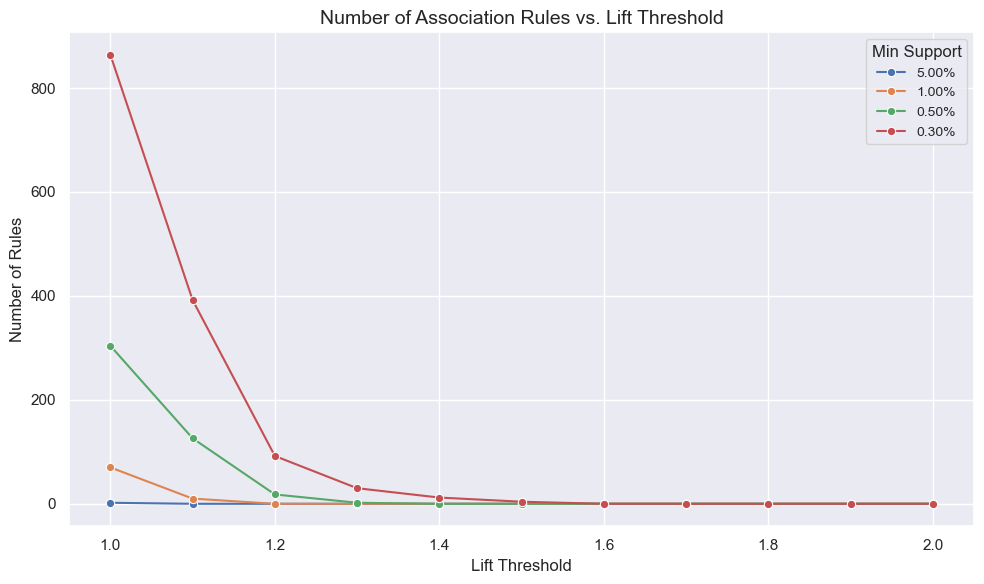

In [160]:
support_levels  = [0.05, 0.01, 0.005, 0.003]
lift_thresholds = np.arange(1.0, 2.1, 0.1)
records = []

for sup in support_levels:
    # mine frequent itemsets at this support
    freq_itemsets = fpgrowth(binary_foodmart, min_support=sup, use_colnames=True)
    # generate all rules with lift >= 1.0
    rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.0)
    # count how many rules survive each lift threshold
    for lt in lift_thresholds:
        count = (rules['lift'] >= lt).sum()
        records.append({
            'Support': f"{sup*100:.2f}%",
            'Lift Threshold': lt,
            'Rule Count': count
        })

plot_df = pd.DataFrame(records)

# Plot with seaborn
sns.set_theme(style="darkgrid", palette="deep")
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_df,
    x='Lift Threshold',
    y='Rule Count',
    hue='Support',
    marker='o'
)
plt.title('Number of Association Rules vs. Lift Threshold', fontsize=14)
plt.xlabel('Lift Threshold', fontsize=12)
plt.ylabel('Number of Rules', fontsize=12)
plt.legend(title='Min Support', title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()

##### Association Rules - Minimum Support Threshold == 1%

In [162]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='lift', min_threshold=1)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('lift', ascending=False).head(20)

Number of rules generated: 70


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
63,(Soup),(Wine),0.011273,784.0,0.093892,1.163805,0.001587,1.014585
62,(Wine),(Soup),0.011273,784.0,0.139726,1.163805,0.001587,1.022860
43,(Fresh Fruit),(Juice),0.010769,749.0,0.061439,1.144350,0.001358,1.008257
42,(Juice),(Fresh Fruit),0.010769,749.0,0.200589,1.144350,0.001358,1.031652
52,(Batteries),(Fresh Fruit),0.010798,751.0,0.200107,1.141597,0.001339,1.031029
53,(Fresh Fruit),(Batteries),0.010798,751.0,0.061603,1.141597,0.001339,1.008142
69,(Fresh Fruit),(Pizza),0.010654,741.0,0.060783,1.124598,0.001180,1.007170
68,(Pizza),(Fresh Fruit),0.010654,741.0,0.197127,1.124598,0.001180,1.027203
27,(Fresh Fruit),(Sliced Bread),0.010942,761.0,0.062423,1.108365,0.001070,1.006509
26,(Sliced Bread),(Fresh Fruit),0.010942,761.0,0.194281,1.108365,0.001070,1.023575


In [174]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='lift', min_threshold=1.05)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('lift', ascending=False).head(20)

Number of rules generated: 36


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
29,(Soup),(Wine),0.011273,784.0,0.093892,1.163805,0.001587,1.014585
28,(Wine),(Soup),0.011273,784.0,0.139726,1.163805,0.001587,1.022860
21,(Fresh Fruit),(Juice),0.010769,749.0,0.061439,1.144350,0.001358,1.008257
20,(Juice),(Fresh Fruit),0.010769,749.0,0.200589,1.144350,0.001358,1.031652
26,(Batteries),(Fresh Fruit),0.010798,751.0,0.200107,1.141597,0.001339,1.031029
27,(Fresh Fruit),(Batteries),0.010798,751.0,0.061603,1.141597,0.001339,1.008142
35,(Fresh Fruit),(Pizza),0.010654,741.0,0.060783,1.124598,0.001180,1.007170
34,(Pizza),(Fresh Fruit),0.010654,741.0,0.197127,1.124598,0.001180,1.027203
10,(Sliced Bread),(Fresh Fruit),0.010942,761.0,0.194281,1.108365,0.001070,1.023575
11,(Fresh Fruit),(Sliced Bread),0.010942,761.0,0.062423,1.108365,0.001070,1.006509


In [176]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='lift', min_threshold=1.1)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('lift', ascending=False).head(20)

Number of rules generated: 10


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
7,(Soup),(Wine),0.011273,784.0,0.093892,1.163805,0.001587,1.014585
6,(Wine),(Soup),0.011273,784.0,0.139726,1.163805,0.001587,1.022860
3,(Fresh Fruit),(Juice),0.010769,749.0,0.061439,1.144350,0.001358,1.008257
2,(Juice),(Fresh Fruit),0.010769,749.0,0.200589,1.144350,0.001358,1.031652
4,(Batteries),(Fresh Fruit),0.010798,751.0,0.200107,1.141597,0.001339,1.031029
5,(Fresh Fruit),(Batteries),0.010798,751.0,0.061603,1.141597,0.001339,1.008142
8,(Pizza),(Fresh Fruit),0.010654,741.0,0.197127,1.124598,0.001180,1.027203
9,(Fresh Fruit),(Pizza),0.010654,741.0,0.060783,1.124598,0.001180,1.007170
0,(Sliced Bread),(Fresh Fruit),0.010942,761.0,0.194281,1.108365,0.001070,1.023575
1,(Fresh Fruit),(Sliced Bread),0.010942,761.0,0.062423,1.108365,0.001070,1.006509


In [179]:
rules_1   = generate_rules(binary_foodmart, 0.01, metric='lift', min_threshold=1.15)
print("Number of rules generated:", len(rules_1))
rules_1.sort_values('lift', ascending=False).head(20)

Number of rules generated: 2


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
1,(Soup),(Wine),0.011273,784.0,0.093892,1.163805,0.001587,1.014585
0,(Wine),(Soup),0.011273,784.0,0.139726,1.163805,0.001587,1.022860


**We'll use the same formatting function using before in the confidence association rules adapted for the lift.**

##### Association Rules - Minimum Support Threshold == 0.5%

In [180]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 304


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
280,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
281,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122
182,(Soda),(Canned Vegetables),0.005320,370.0,0.101537,1.292656,0.001204,1.025586
183,(Canned Vegetables),(Soda),0.005320,370.0,0.067728,1.292656,0.001204,1.016448
173,(Canned Vegetables),(Waffles),0.005435,378.0,0.069193,1.266725,0.001144,1.015652
172,(Waffles),(Canned Vegetables),0.005435,378.0,0.099500,1.266725,0.001144,1.023266
57,(Eggs),(Milk),0.005306,369.0,0.082810,1.248230,0.001055,1.017955
56,(Milk),(Eggs),0.005306,369.0,0.079974,1.248230,0.001055,1.017287
93,(Fresh Fruit),(Rice),0.006844,476.0,0.039045,1.223774,0.001251,1.007430
92,(Rice),(Fresh Fruit),0.006844,476.0,0.214511,1.223774,0.001251,1.049936


In [181]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.05)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 198


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
181,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122
180,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
112,(Soda),(Canned Vegetables),0.005320,370.0,0.101537,1.292656,0.001204,1.025586
113,(Canned Vegetables),(Soda),0.005320,370.0,0.067728,1.292656,0.001204,1.016448
106,(Waffles),(Canned Vegetables),0.005435,378.0,0.099500,1.266725,0.001144,1.023266
107,(Canned Vegetables),(Waffles),0.005435,378.0,0.069193,1.266725,0.001144,1.015652
37,(Eggs),(Milk),0.005306,369.0,0.082810,1.248230,0.001055,1.017955
36,(Milk),(Eggs),0.005306,369.0,0.079974,1.248230,0.001055,1.017287
53,(Fresh Fruit),(Rice),0.006844,476.0,0.039045,1.223774,0.001251,1.007430
52,(Rice),(Fresh Fruit),0.006844,476.0,0.214511,1.223774,0.001251,1.049936


In [182]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.1)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 126


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
117,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122
116,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
63,(Canned Vegetables),(Soda),0.005320,370.0,0.067728,1.292656,0.001204,1.016448
62,(Soda),(Canned Vegetables),0.005320,370.0,0.101537,1.292656,0.001204,1.025586
61,(Canned Vegetables),(Waffles),0.005435,378.0,0.069193,1.266725,0.001144,1.015652
60,(Waffles),(Canned Vegetables),0.005435,378.0,0.099500,1.266725,0.001144,1.023266
25,(Eggs),(Milk),0.005306,369.0,0.082810,1.248230,0.001055,1.017955
24,(Milk),(Eggs),0.005306,369.0,0.079974,1.248230,0.001055,1.017287
36,(Rice),(Fresh Fruit),0.006844,476.0,0.214511,1.223774,0.001251,1.049936
37,(Fresh Fruit),(Rice),0.006844,476.0,0.039045,1.223774,0.001251,1.007430


In [183]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.15)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 54


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
49,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122
48,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
31,(Canned Vegetables),(Soda),0.005320,370.0,0.067728,1.292656,0.001204,1.016448
30,(Soda),(Canned Vegetables),0.005320,370.0,0.101537,1.292656,0.001204,1.025586
29,(Canned Vegetables),(Waffles),0.005435,378.0,0.069193,1.266725,0.001144,1.015652
28,(Waffles),(Canned Vegetables),0.005435,378.0,0.099500,1.266725,0.001144,1.023266
15,(Eggs),(Milk),0.005306,369.0,0.082810,1.248230,0.001055,1.017955
14,(Milk),(Eggs),0.005306,369.0,0.079974,1.248230,0.001055,1.017287
21,(Fresh Fruit),(Rice),0.006844,476.0,0.039045,1.223774,0.001251,1.007430
20,(Rice),(Fresh Fruit),0.006844,476.0,0.214511,1.223774,0.001251,1.049936


In [184]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.2)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 18


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
17,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122
16,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
11,(Canned Vegetables),(Soda),0.005320,370.0,0.067728,1.292656,0.001204,1.016448
10,(Soda),(Canned Vegetables),0.005320,370.0,0.101537,1.292656,0.001204,1.025586
8,(Waffles),(Canned Vegetables),0.005435,378.0,0.099500,1.266725,0.001144,1.023266
9,(Canned Vegetables),(Waffles),0.005435,378.0,0.069193,1.266725,0.001144,1.015652
3,(Eggs),(Milk),0.005306,369.0,0.082810,1.248230,0.001055,1.017955
2,(Milk),(Eggs),0.005306,369.0,0.079974,1.248230,0.001055,1.017287
5,(Fresh Fruit),(Rice),0.006844,476.0,0.039045,1.223774,0.001251,1.007430
4,(Rice),(Fresh Fruit),0.006844,476.0,0.214511,1.223774,0.001251,1.049936


In [185]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.25)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 6


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
4,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
5,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122
2,(Soda),(Canned Vegetables),0.005320,370.0,0.101537,1.292656,0.001204,1.025586
3,(Canned Vegetables),(Soda),0.005320,370.0,0.067728,1.292656,0.001204,1.016448
0,(Waffles),(Canned Vegetables),0.005435,378.0,0.099500,1.266725,0.001144,1.023266
1,(Canned Vegetables),(Waffles),0.005435,378.0,0.069193,1.266725,0.001144,1.015652


In [186]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='lift', min_threshold=1.3)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 2


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
0,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
1,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122


##### Association Rules - Minimum Support Threshold == 0.1%


In [28]:
rules_01   = generate_rules(binary_foodmart, 0.003, metric='lift', min_threshold=1.2)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('lift', ascending=False).head(20)

Number of rules generated: 92


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
30,(Hot Dogs),(Pasta),0.003034,211.0,0.075036,1.524583,0.001044,1.027913
31,(Pasta),(Hot Dogs),0.003034,211.0,0.061642,1.524583,0.001044,1.022603
75,(Deli Salads),(Juice),0.003379,235.0,0.081512,1.518238,0.001153,1.030293
74,(Juice),(Deli Salads),0.003379,235.0,0.062935,1.518238,0.001153,1.022925
65,(Waffles),(Frozen Chicken),0.003321,231.0,0.060805,1.490120,0.001092,1.021295
64,(Frozen Chicken),(Waffles),0.003321,231.0,0.081395,1.490120,0.001092,1.029144
55,(Pizza),(Ice Cream),0.003393,236.0,0.062783,1.477655,0.001097,1.021654
54,(Ice Cream),(Pizza),0.003393,236.0,0.079865,1.477655,0.001097,1.028057
79,(Pizza),(Deli Salads),0.003264,227.0,0.060388,1.456799,0.001023,1.020153
78,(Deli Salads),(Pizza),0.003264,227.0,0.078737,1.456799,0.001023,1.026799


In [29]:
rules_01   = generate_rules(binary_foodmart, 0.003, metric='lift', min_threshold=1.3)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('lift', ascending=False).head(20)

Number of rules generated: 30


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
2,(Hot Dogs),(Pasta),0.003034,211.0,0.075036,1.524583,0.001044,1.027913
3,(Pasta),(Hot Dogs),0.003034,211.0,0.061642,1.524583,0.001044,1.022603
15,(Deli Salads),(Juice),0.003379,235.0,0.081512,1.518238,0.001153,1.030293
14,(Juice),(Deli Salads),0.003379,235.0,0.062935,1.518238,0.001153,1.022925
11,(Waffles),(Frozen Chicken),0.003321,231.0,0.060805,1.490120,0.001092,1.021295
10,(Frozen Chicken),(Waffles),0.003321,231.0,0.081395,1.490120,0.001092,1.029144
9,(Pizza),(Ice Cream),0.003393,236.0,0.062783,1.477655,0.001097,1.021654
8,(Ice Cream),(Pizza),0.003393,236.0,0.079865,1.477655,0.001097,1.028057
19,(Pizza),(Deli Salads),0.003264,227.0,0.060388,1.456799,0.001023,1.020153
18,(Deli Salads),(Pizza),0.003264,227.0,0.078737,1.456799,0.001023,1.026799


In [30]:
rules_01   = generate_rules(binary_foodmart, 0.003, metric='lift', min_threshold=1.4)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('lift', ascending=False).head(20)

Number of rules generated: 12


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
2,(Hot Dogs),(Pasta),0.003034,211.0,0.075036,1.524583,0.001044,1.027913
3,(Pasta),(Hot Dogs),0.003034,211.0,0.061642,1.524583,0.001044,1.022603
8,(Juice),(Deli Salads),0.003379,235.0,0.062935,1.518238,0.001153,1.022925
9,(Deli Salads),(Juice),0.003379,235.0,0.081512,1.518238,0.001153,1.030293
7,(Waffles),(Frozen Chicken),0.003321,231.0,0.060805,1.490120,0.001092,1.021295
6,(Frozen Chicken),(Waffles),0.003321,231.0,0.081395,1.490120,0.001092,1.029144
5,(Pizza),(Ice Cream),0.003393,236.0,0.062783,1.477655,0.001097,1.021654
4,(Ice Cream),(Pizza),0.003393,236.0,0.079865,1.477655,0.001097,1.028057
10,(Deli Salads),(Pizza),0.003264,227.0,0.078737,1.456799,0.001023,1.026799
11,(Pizza),(Deli Salads),0.003264,227.0,0.060388,1.456799,0.001023,1.020153


In [31]:
rules_01   = generate_rules(binary_foodmart, 0.003, metric='lift', min_threshold=1.5)
print("Number of rules generated:", len(rules_01))
rules_01.sort_values('lift', ascending=False).head(20)

Number of rules generated: 4


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
0,(Hot Dogs),(Pasta),0.003034,211.0,0.075036,1.524583,0.001044,1.027913
1,(Pasta),(Hot Dogs),0.003034,211.0,0.061642,1.524583,0.001044,1.022603
2,(Juice),(Deli Salads),0.003379,235.0,0.062935,1.518238,0.001153,1.022925
3,(Deli Salads),(Juice),0.003379,235.0,0.081512,1.518238,0.001153,1.030293


##### 1.3.2.1. Discussing Results

**Using lift alone shows how quickly meaningful associations vanish as support is tightened.**

When the minimum support is **1 %** (about seven hundred baskets) every rule’s lift hovers around **1.1** and, once the lift filter reaches **1.15**, the dataset retains only the symmetric **Soup ↔ Wine** pair—****evidence**** that, at this frequency, co‑purchases are essentially random.

Lowering the support floor to **0.5 %** (roughly three‑hundred‑fifty baskets) uncovers moderate affinities: lifts climb to about **1.39** and pairs such as **Deli Salads ↔ Cheese** or **Soda ↔ Canned Vegetables** appear, yet raising the lift bar from **1.0** to **1.3** still collapses the rule list from more than three hundred to just two.

A further drop to **0.3 %** support reveals the genuinely strong global links: **Hot Dogs ↔ Pasta**, **Deli Salads ↔ Juice**, **Waffles ↔ Frozen Chicken** and **Pizza ↔ Ice‑Cream** all exceed a lift of **1.5**, but only four rules survive this threshold, which keeps the output compact. Multi‑item antecedents are virtually absent—only `{Soup, Fresh Fruit} → Fresh Vegetables` clears support **0.5 %**, because larger combinations quickly fall below any realistic frequency cut‑off.

Even these best global lift rules have **leverage** of about **0.001–0.002**: not good.

* The **modest lifts themselves are almost likely the result of pooling transactions from the five very different store formats**. <ins>Strong affinities that hold inside one format are diluted when counts are averaged across all stores, a classical case of **Simpson’s paradox**</ins>.

**Segmenting the data by store type and re‑mining is probably the only thing able to fix this,**  

<ins>But for the aggregate dataset a support window of **0.3–0.5%** combined with a lift floor near **1.3** strikes the best balance between statistical stability and managerial usefulness.</ins>


#### 1.3.3 Association Rules with both chosen Confidence and Lift values 

In [42]:
# frequent itemsets
min_sup   = 0.005
freq_items = fpgrowth(binary_foodmart, min_support=min_sup, use_colnames=True)

# all rules at confidence ≥ 0.30
min_conf  = 0.20
rules     = association_rules(freq_items, metric="confidence", min_threshold=min_conf)

# Filter for lift ≥ 1.20
min_lift  = 1.1
strong_rules = rules[rules['lift'] >= min_lift].copy()

# absolute counts
strong_rules['count'] = strong_rules['support'] * binary_foodmart.shape[0]

strong_rules = strong_rules.sort_values(['lift','confidence'], ascending=False)
print(f"Found {len(strong_rules)} rules with support ≥ {min_sup*100:.1f}%, "
      f"confidence ≥ {min_conf:.2f}, lift ≥ {min_lift:.2f}\n")
strong_rules[[
    'antecedents','consequents',
    'support','count',
    'confidence','lift',
    'leverage','conviction'
]].head(20)


Found 10 rules with support ≥ 0.5%, confidence ≥ 0.20, lift ≥ 1.10



,antecedents,consequents,support,count,confidence,lift,leverage,conviction
21,(Rice),(Fresh Fruit),0.006844,476.0,0.214511,1.223774,0.001251,1.049936
63,(TV Dinner),(Fresh Fruit),0.008843,615.0,0.211558,1.206929,0.001516,1.046004
1,"(Fresh Fruit, Soup)",(Fresh Vegetables),0.007089,493.0,0.340705,1.197720,0.001170,1.085309
54,(Mouthwash),(Fresh Fruit),0.005866,408.0,0.209877,1.197334,0.000967,1.043778
9,(Hard Candy),(Fresh Fruit),0.005708,397.0,0.207311,1.182696,0.000882,1.040399
23,(Flavored Drinks),(Fresh Fruit),0.008383,583.0,0.205789,1.174015,0.001242,1.038406
44,(Juice),(Fresh Fruit),0.010769,749.0,0.200589,1.144350,0.001358,1.031652
60,(Batteries),(Fresh Fruit),0.010798,751.0,0.200107,1.141597,0.001339,1.031029
70,(Aspirin),(Fresh Vegetables),0.008613,599.0,0.322911,1.135167,0.001026,1.056787
55,(Hamburger),(Fresh Vegetables),0.008943,622.0,0.316057,1.111072,0.000894,1.046196


In [49]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='leverage', min_threshold=0.0018)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 4


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
2,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
3,(Cheese),(Deli Salads),0.006787,472.0,0.057589,1.389269,0.001902,1.017122
0,(Fresh Vegetables),(Dried Fruit),0.035284,2454.0,0.124040,1.058118,0.001938,1.007778
1,(Dried Fruit),(Fresh Vegetables),0.035284,2454.0,0.300993,1.058118,0.001938,1.023651


In [55]:
rules_05   = generate_rules(binary_foodmart, 0.005, metric='conviction', min_threshold=1.05)
print("Number of rules generated:", len(rules_05))
rules_05.sort_values('lift', ascending=False).head(20)

Number of rules generated: 3


,antecedents,consequents,support,count,confidence,lift,leverage,conviction
1,(Deli Salads),(Cheese),0.006787,472.0,0.163718,1.389269,0.001902,1.054854
0,"(Fresh Fruit, Soup)",(Fresh Vegetables),0.007089,493.0,0.340705,1.197720,0.001170,1.085309
2,(Aspirin),(Fresh Vegetables),0.008613,599.0,0.322911,1.135167,0.001026,1.056787


##### 1.3.3.1. Discussing Results

To fully understand the results we also have to get what **Leverage** and **Conviction** are:

**Leverage** (also known as *Piatetsky‑Snapiro* measure)  
Computes the difference between the observed joint frequency of **X** and **Y** and the frequency we would expect if **X** and **Y** were independent:

`Leverage(X → Y) = support(X ∪ Y) − support(X) × support(Y)`

- **Range:** [−1, 1]  
- **Interpretation:**  
  - <ins>Leverage > 0</ins> means **X** and **Y** co‑occur more often than expected (positive correlation).  
  - <ins>Leverage < 0</ins> means they co‑occur less than expected (negative correlation).  
  - <ins>Leverage = 0</ins> indicates statistical independence.


**Conviction**  
Measures how often **X** occurs without **Y** (i.e. the rule “fails”) compared to the failure rate if **X** and **Y** were independent:

`Conviction(X → Y) = (1 − support(Y)) / (1 − confidence(X → Y))`

- **Range:** [0, ∞)  
- **Interpretation:**  
  - <ins>Conviction > 1</ins> means **Y** is more likely when **X** is present (fewer failures than expected).  
  - <ins>Conviction = 1</ins> indicates independence.  
  - As confidence → 1, conviction → ∞ (perfect implication).

Applying the **joint filter** (<ins>support ≥ 0.5 %, confidence ≥ 20 %, lift ≥ 1.20</ins>) collapses the rule‑set to only two associations: 
 * `Rice → Fresh Fruit` 
 * and `TV Dinner → Fresh Fruit`. 
 
Both satisfy the statistical criteria—their supports hover around **0.7–0.9%** (210–615 baskets), confidence is slightly above one purchase in five, and lift shows that Fresh Fruit is chosen about **20%** more often than random when these antecedents are present. 

Yet the effect size remains ***modest***: <ins>leverage is just 0.0013–0.0015</ins>, meaning each rule contributes roughly one extra Fresh‑Fruit sale per thousand baskets. Because **Fresh Fruit** is THE SECOND MOST POPULAR item, the rules mostly reflect its base popularity rather than a uniquely strong tie to Rice or TV Dinners.

Like previously stated segmenting the data by **store type** is likely the only way to improve this, where <ins>context‑specific affinities</ins> may surface with both higher lift and leverage.  

### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets
- discuss their utility compared to frequent patterns
- analyse the association rules they can unravel

In [47]:
# Write code in cells like this
# ....

Write text in cells like this ...


### 1.5 Conclusions from Mining Frequent Patterns in All Stores (Global Patterns and Rules)

Write text in cells like this ...


## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact from purchases carried out in **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores (specific/local patterns), and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store (global patterns). 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse **both** the transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21)** and **Gourmet Supermarkets (STORE_ID = 4, 6)**.

#### 2.1.1. Load/Preprocess the Dataset

**You might need to change a bit the preprocessing, although most of it should be reused.**

In [268]:
# Write code in cells like this
# ....

Write text in cells like this ...


#### 2.1.2. Compute Frequent Itemsets

**This should be trivial now.**

In [273]:
# Write code in cells like this
# ....

Write text in cells like this ...


#### 2.1.3. Generate Association Rules from Frequent Itemsets

**This should be trivial now.**

In [277]:
# Write code in cells like this
# ....

Write text in cells like this 

#### 2.1.4.  Take a look at Maximal Patterns

In [281]:
# Write code in cells like this
# ....

Write text in cells like this 

#### 2.1.5.  Deluxe/Gourmet Supermarkets versus All Stores (Global versus Deluxe/Gourmet Supermarkets Specific Patterns and Rules)

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets).


In [164]:
# Write code in cells like this
# ....

Write text in cells like this 

### 2.2. Analyse Small Groceries

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

**This should be trivial now.**

In [174]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.2. Compute Frequent Itemsets

Write text in cells like this 


In [168]:
# Write code in cells like this
# ....

#### 2.2.3. Generate Association Rules from Frequent Itemsets

In [168]:
# Write code in cells like this
# ....

Write text in cells like this


#### 2.2.4. Take a Look at Maximal Patterns

In [172]:
# Write code in cells like this
# ....

Write text in cells like this


#### 2.2.5. Small Groceries versus All Stores (Global versus Small Groceries Specific Patterns and Rules)

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this


### 2.3.  Deluxe/Gourmet Supermarkets versus Small Groceries

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets) and those obtained in task 2.2. (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this